In [2]:
import os
import re
import pickle
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import pandas as pd
import torch
import tifffile
from sklearn.metrics import adjusted_rand_score
from einops import rearrange

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.datasets as datasets

In [7]:
project_dir = '/data/estorrs/mushroom/data/projects/submission_v1'
output_dir = os.path.join(project_dir, 'analysis', 'kidney')
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [15]:
output_dir

'/data/estorrs/mushroom/data/projects/submission_v1/analysis/kidney'

In [39]:
fps = sorted(utils.listfiles(os.path.join(project_dir, 'kidney'), regex=r'outputs.pkl$'))
fps


['/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK12F-Fp1/mushroom/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK12M-Fp1/mushroom/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK3F-Fp1/mushroom/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK3M-Fp1/mushroom/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92F-Fp1/mushroom/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92F-Fp1/mushroom_0.002res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92F-Fp1/mushroom_0.005res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92F-Fp1/mushroom_0.01res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92F-Fp1/mushroom_0.02res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92F2-Fc1U1Bs2/mushroom/outputs.pkl',
 '/data/estorrs/mushro

## analysis from direct outputs

NMK12F-Fp1


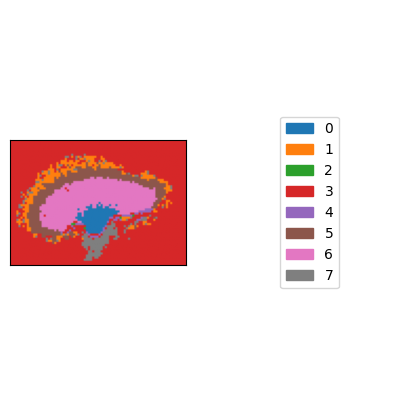

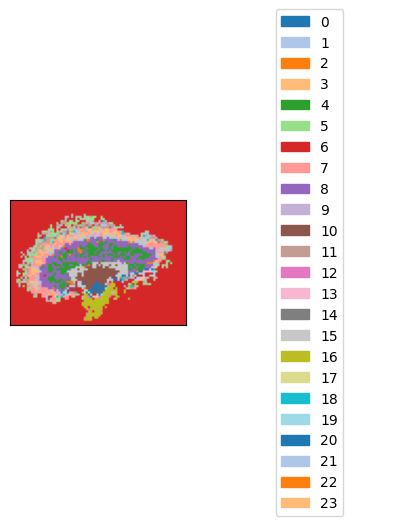

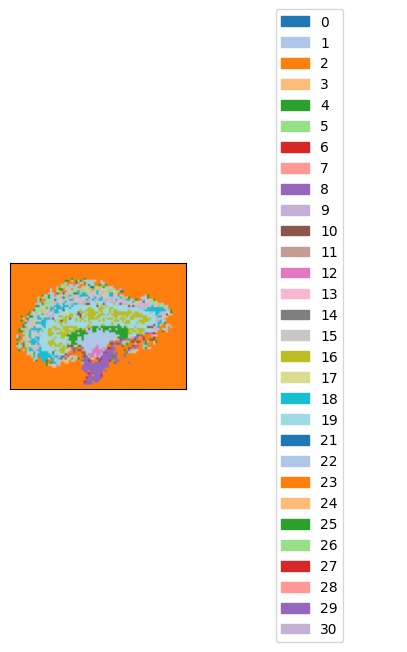

NMK12M-Fp1


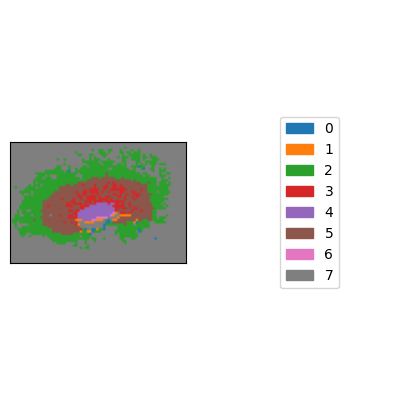

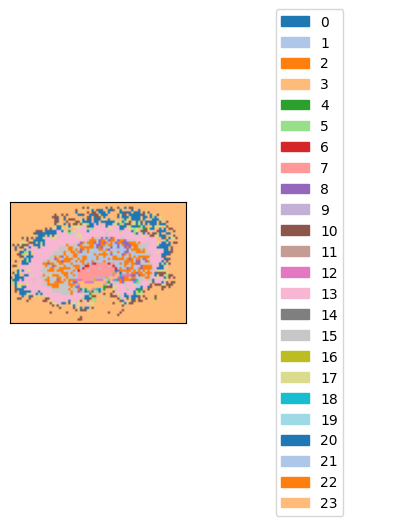

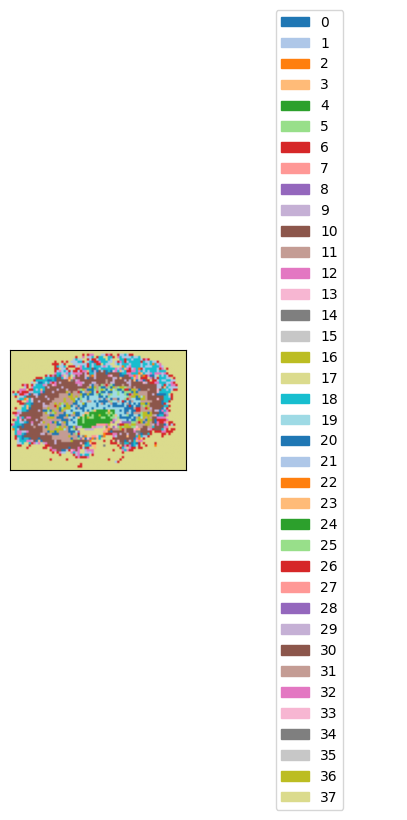

NMK3F-Fp1


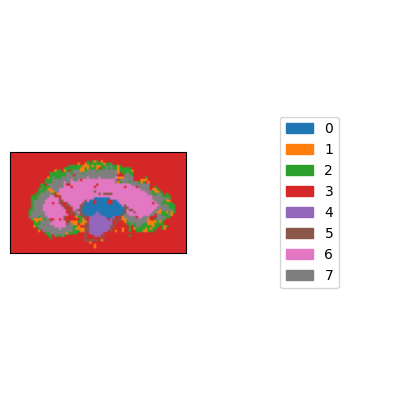

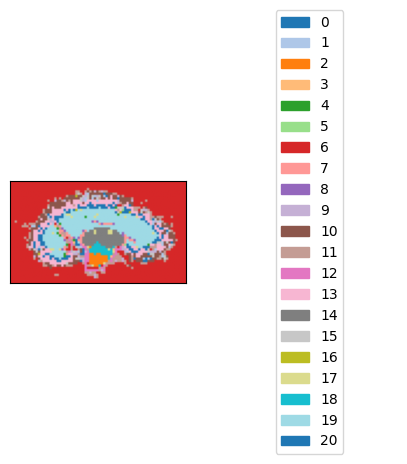

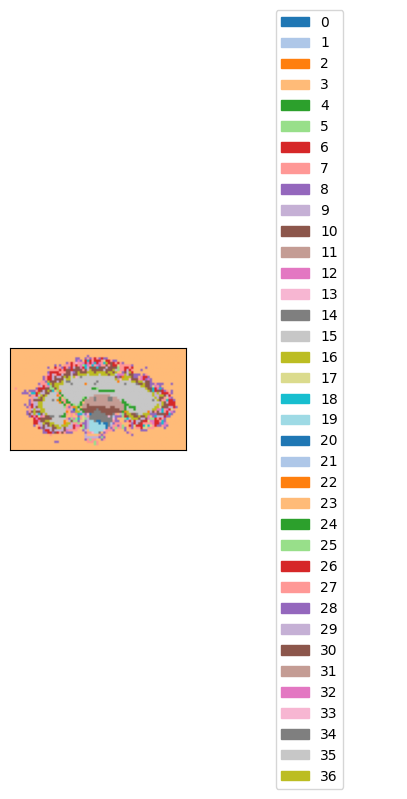

NMK3M-Fp1


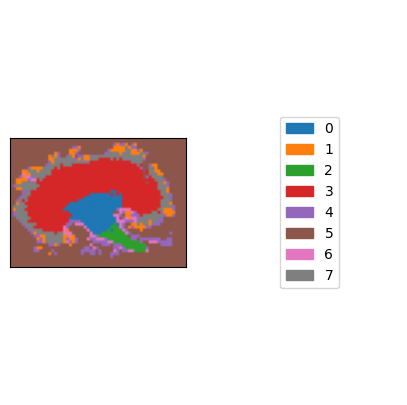

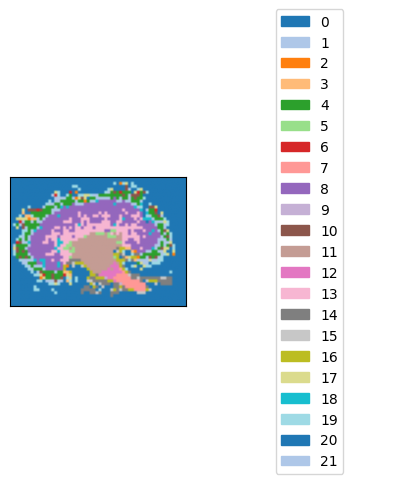

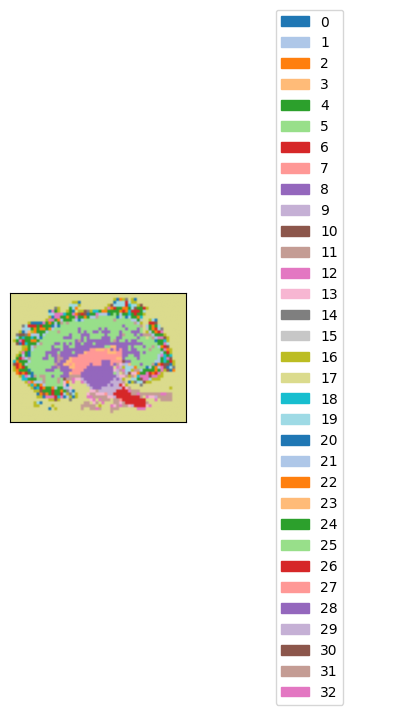

NMK92F-Fp1


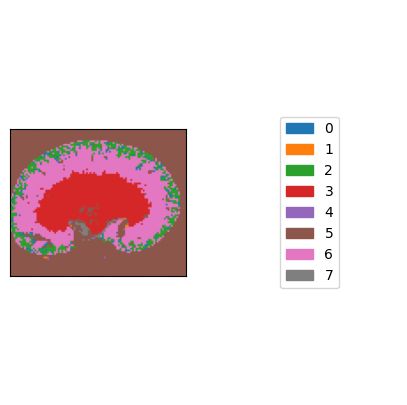

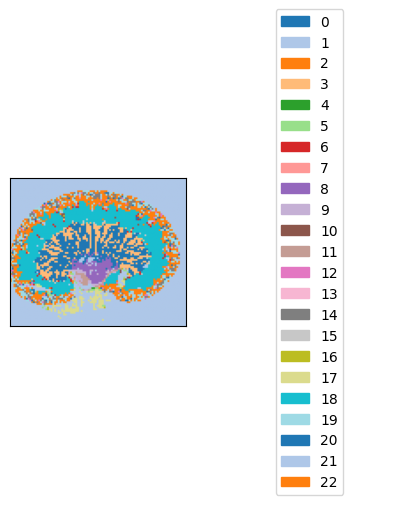

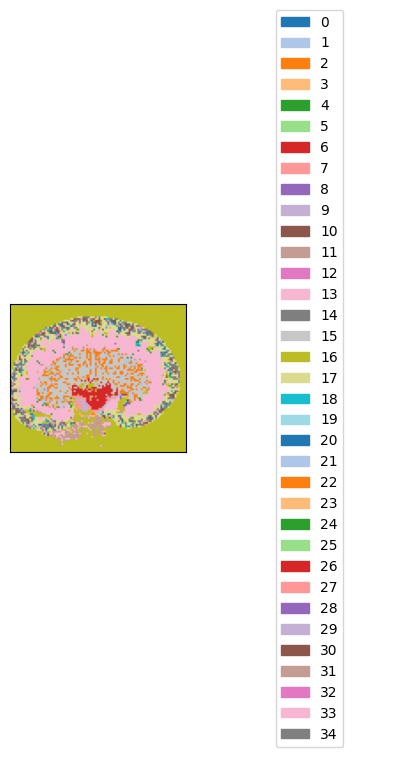

NMK92F2-Fc1U1Bs2


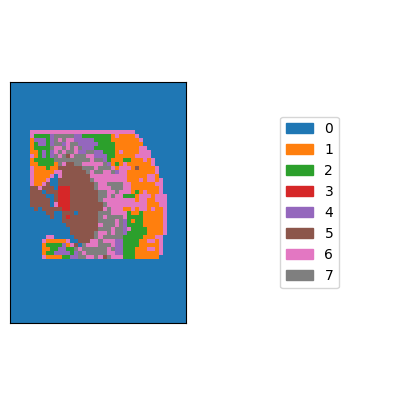

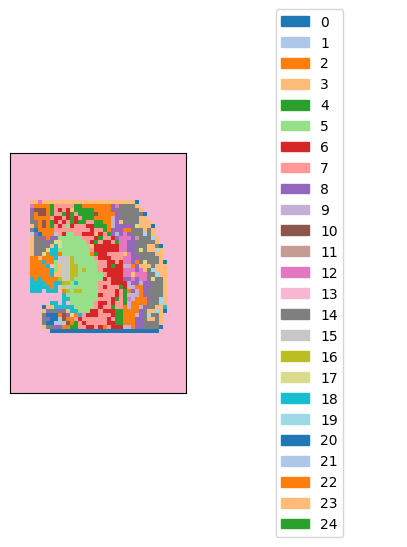

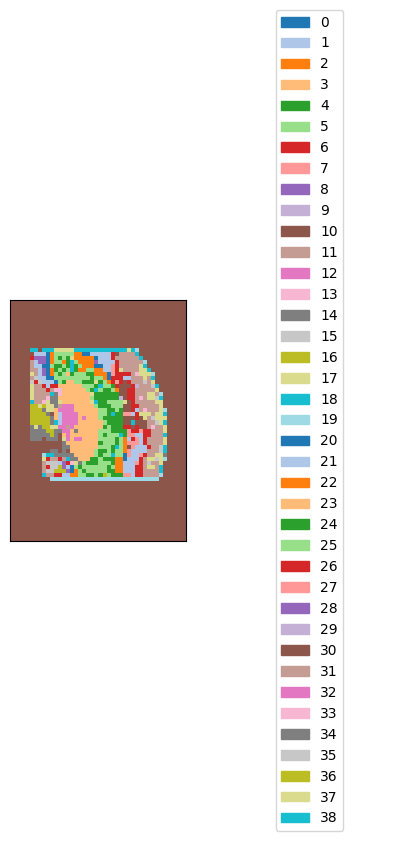

NMK92M-Fp1


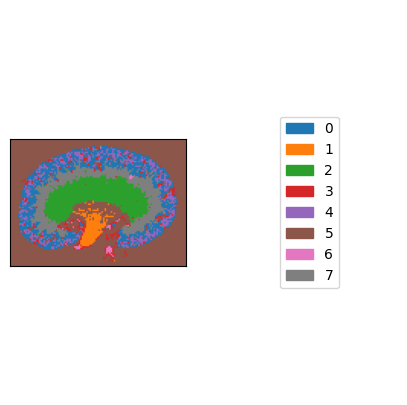

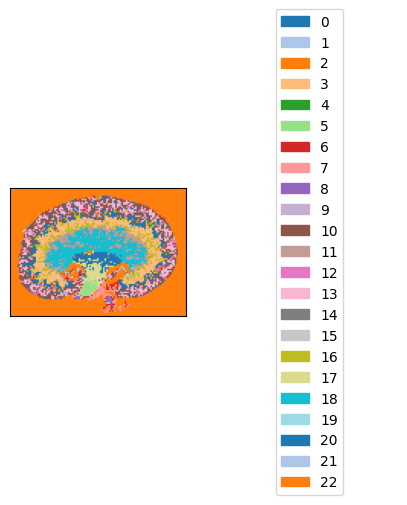

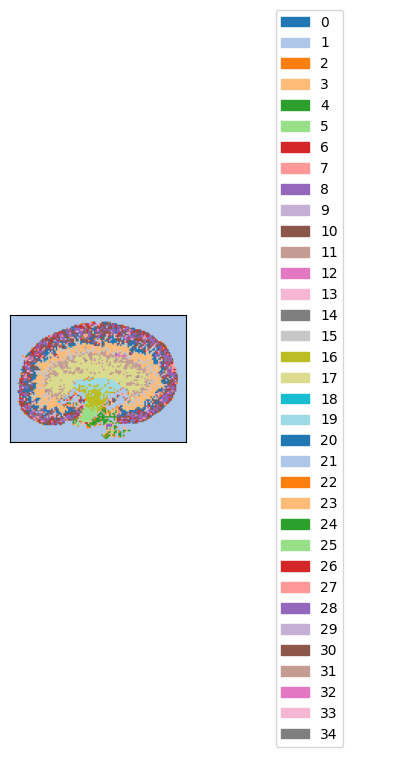

NMK92M1-Fc1U1Bs2


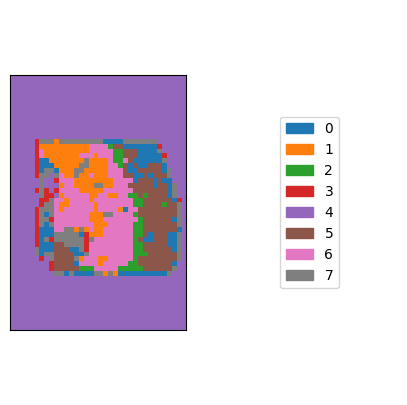

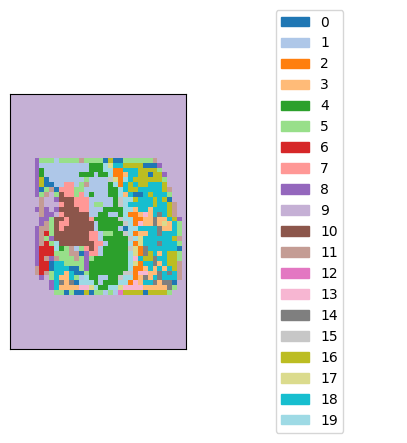

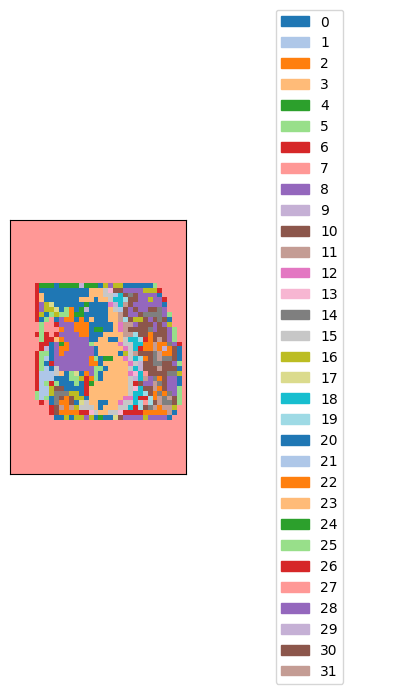

P1F1MnR-Fp1


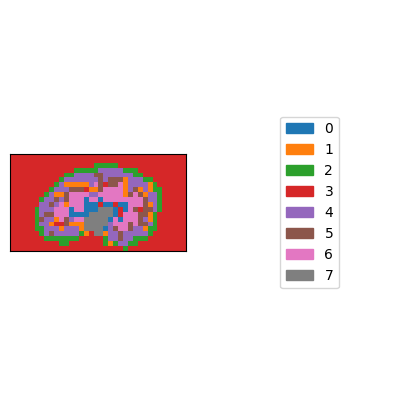

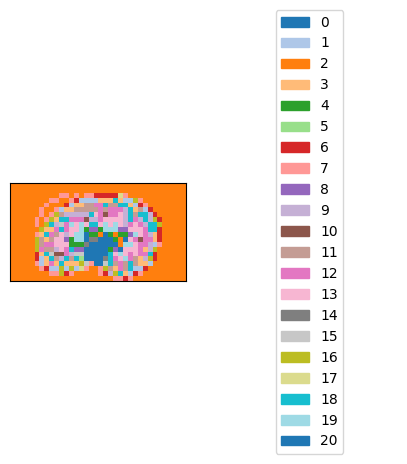

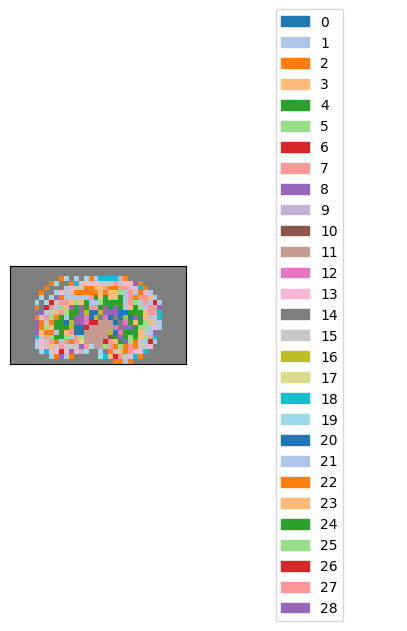

P1M3MnR-Fp1


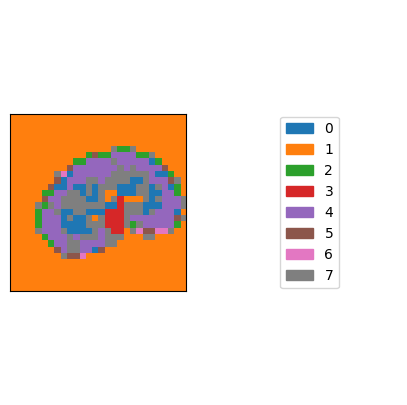

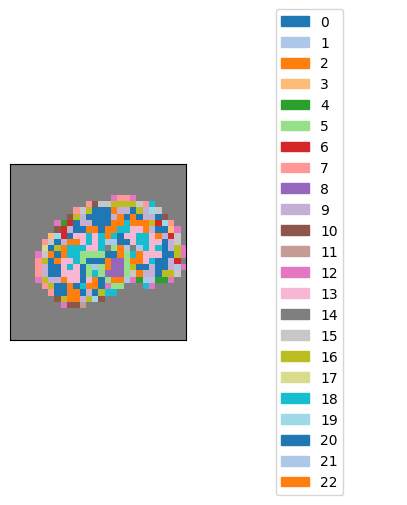

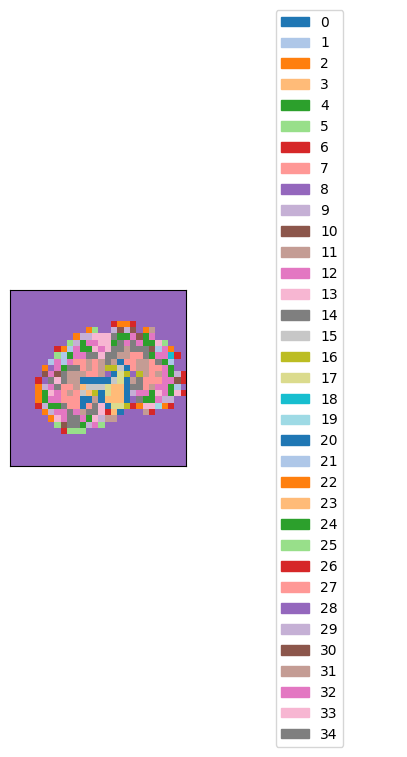

P1_F1LM3l


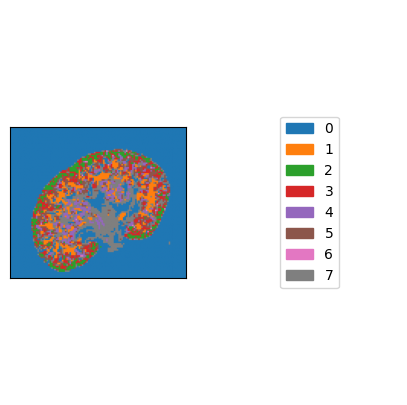

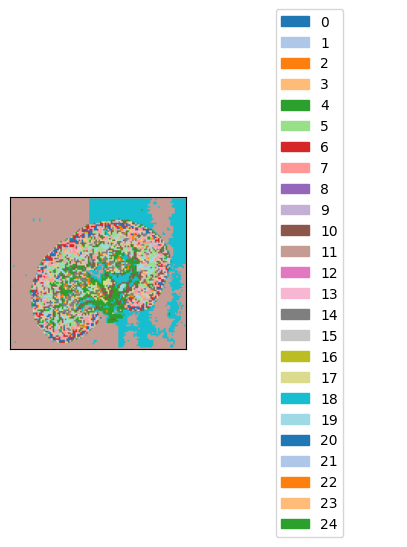

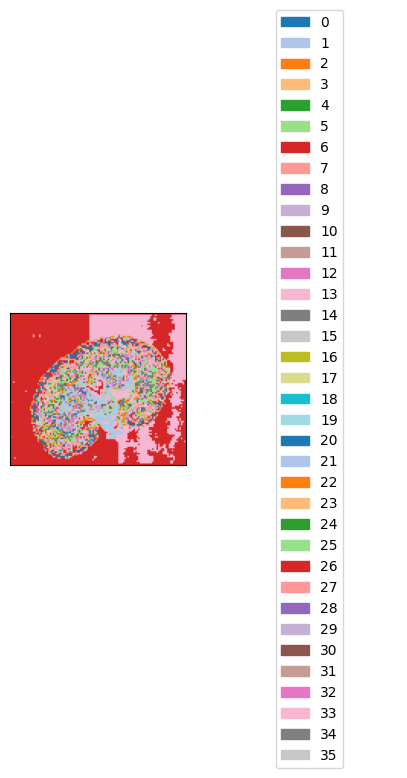

P21_F2RM6R


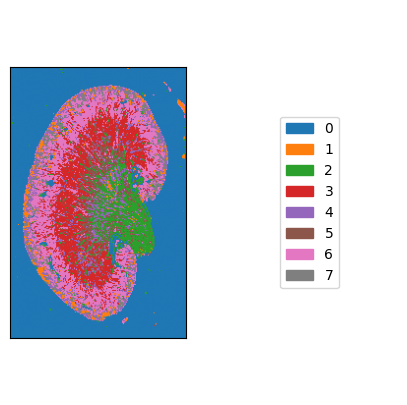

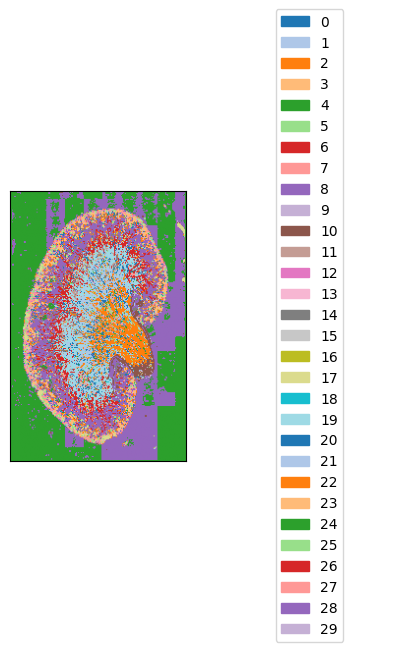

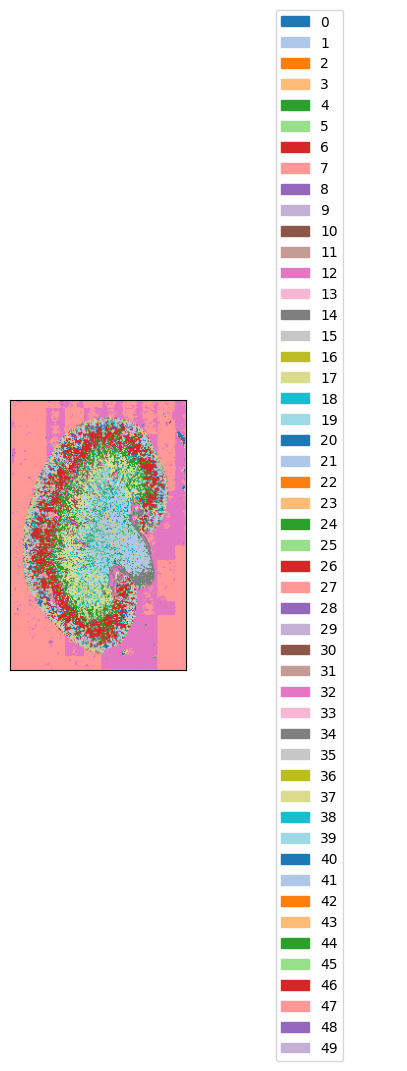

In [9]:
for fp in fps:
    case = fp.split('/')[-3]
    print(case)
    outputs = pickle.load(open(fp, 'rb'))
    k = [x for x in outputs['dtype_to_clusters'].keys() if x != 'integrated'][0]
    clusters = outputs['dtype_to_clusters'][k]
    for i, x in enumerate(clusters):
        vis_utils.display_clusters(x, preserve_indices=True, figsize=(5,5))
        plt.savefig(os.path.join(output_dir, f'{case}_clusters_l{i}.pdf'), dpi=300)
        plt.show()

## spotlight

In [41]:
fps = sorted(utils.listfiles(os.path.join(project_dir, 'kidney'), regex=r'res/outputs.pkl$'))
fps


['/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92F-Fp1/mushroom_0.002res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92F-Fp1/mushroom_0.005res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92F-Fp1/mushroom_0.01res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92F-Fp1/mushroom_0.02res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92F2-Fc1U1Bs2/mushroom_0.001res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92F2-Fc1U1Bs2/mushroom_0.002res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92F2-Fc1U1Bs2/mushroom_0.004res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/P21_F2RM6R/mushroom_0.001res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/P21_F2RM6R/mushroom_0.002res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidn

NMK92F-Fp1


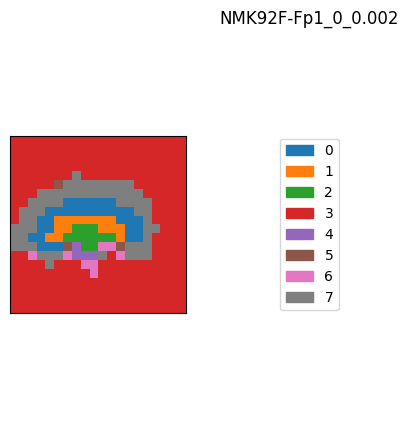

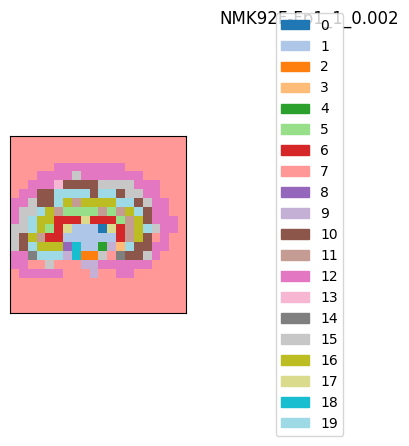

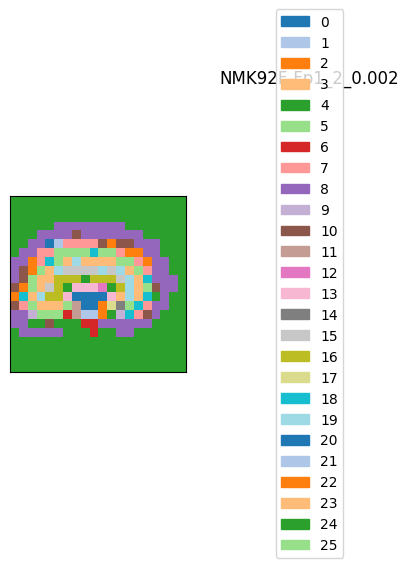

NMK92F-Fp1


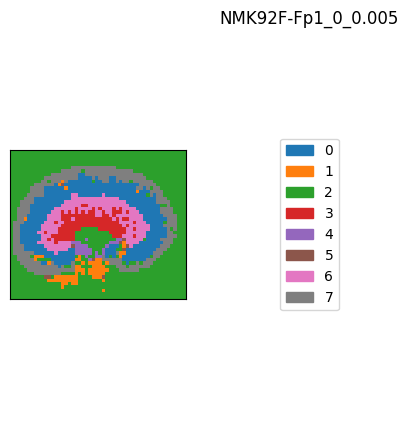

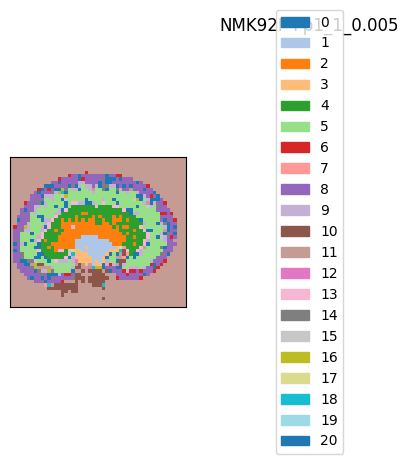

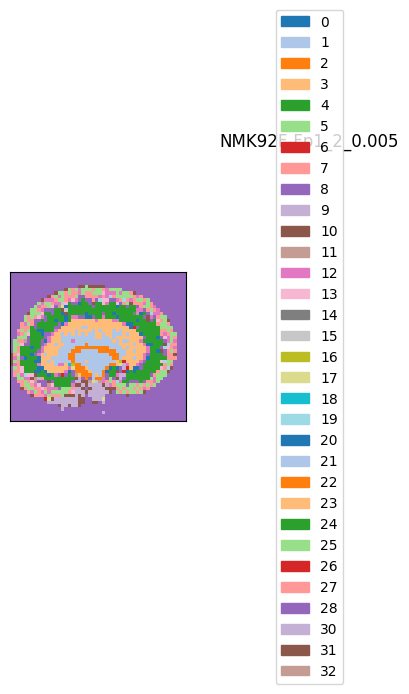

NMK92F-Fp1


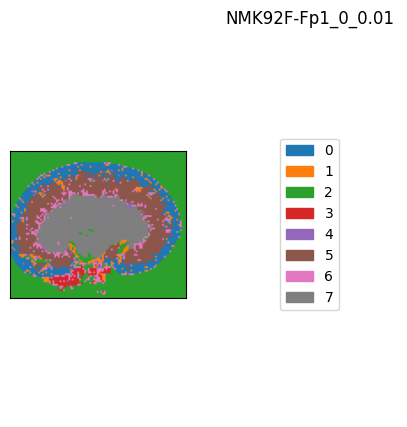

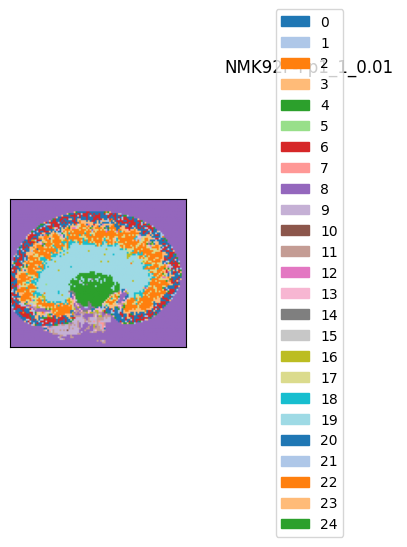

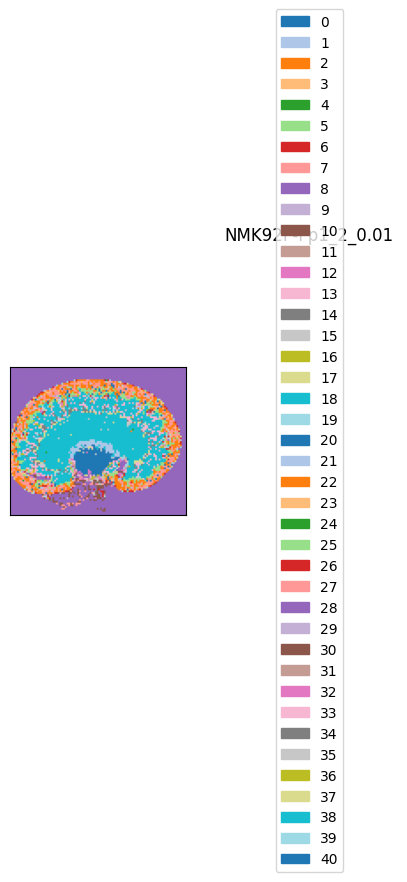

NMK92F-Fp1


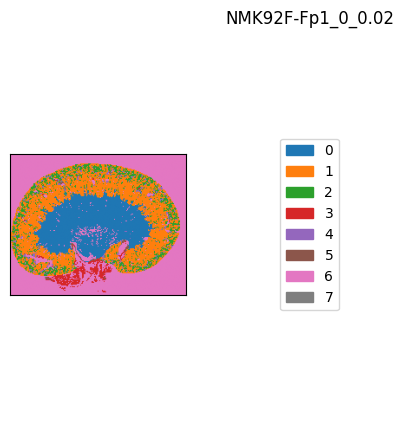

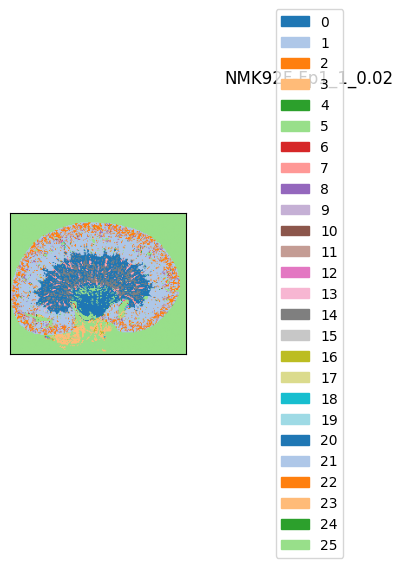

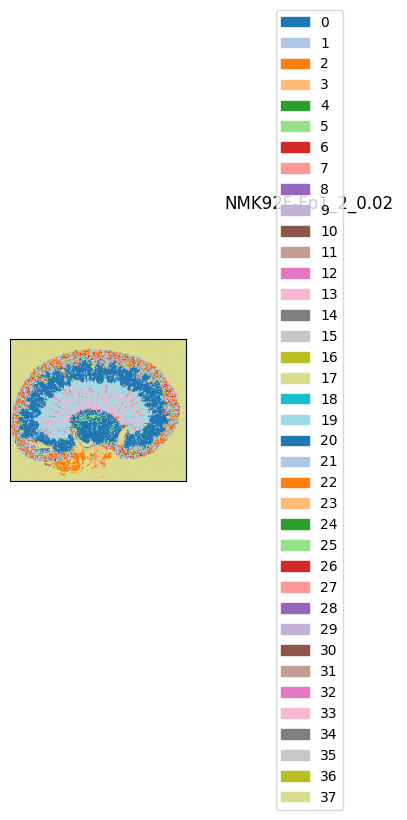

NMK92F2-Fc1U1Bs2


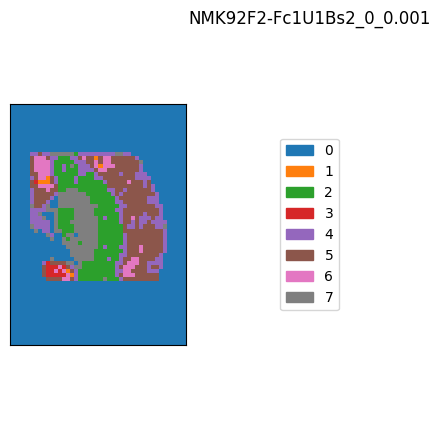

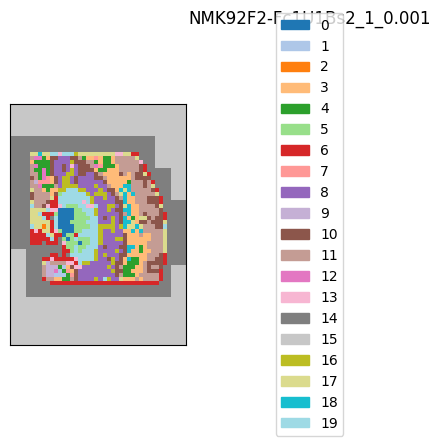

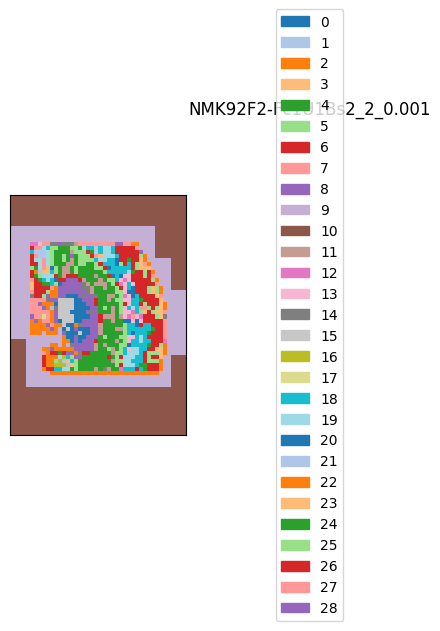

NMK92F2-Fc1U1Bs2


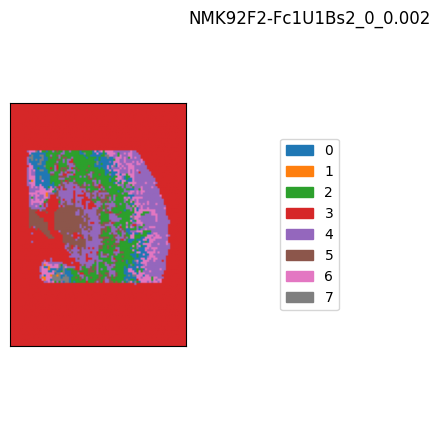

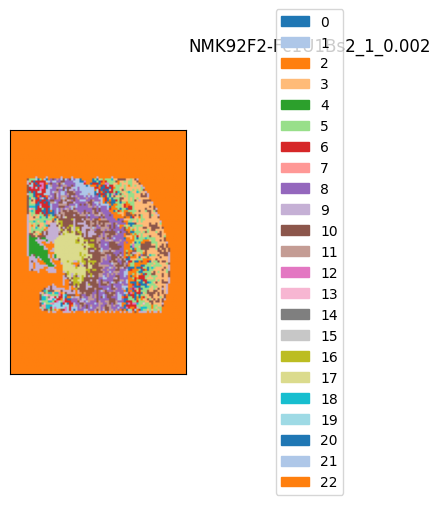

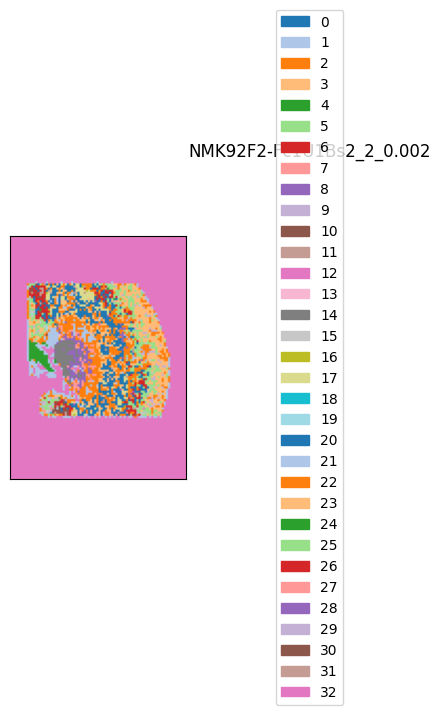

NMK92F2-Fc1U1Bs2


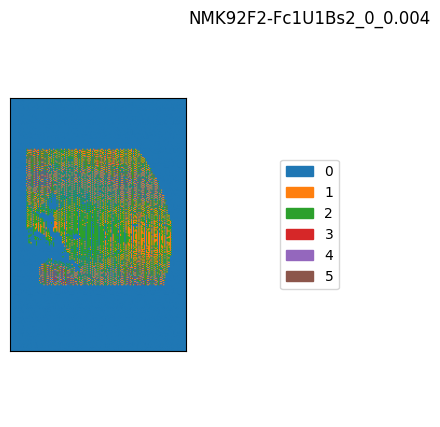

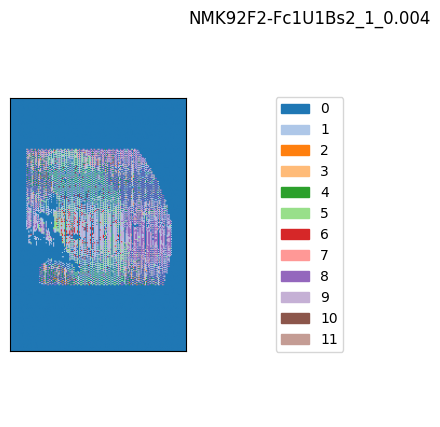

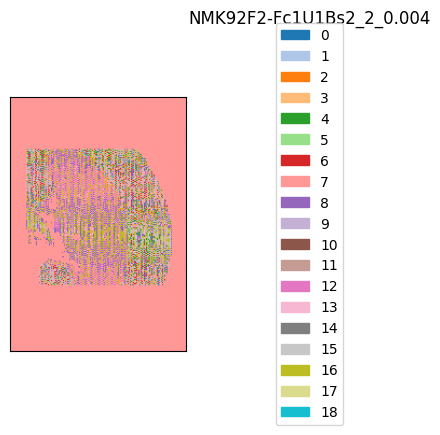

P21_F2RM6R


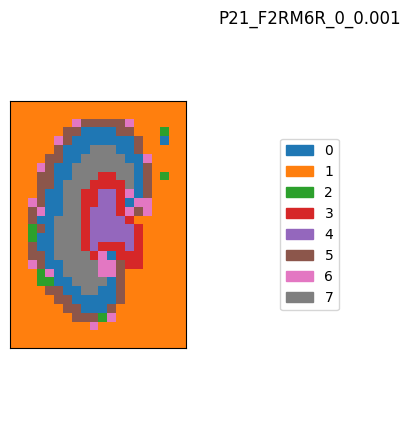

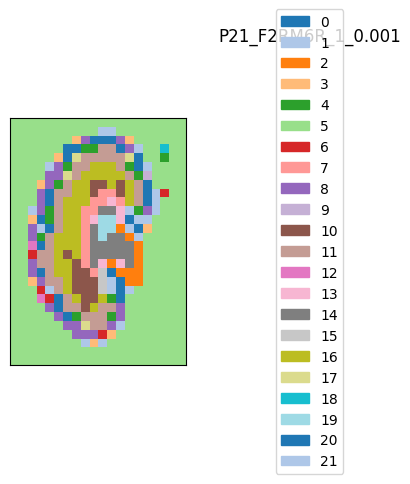

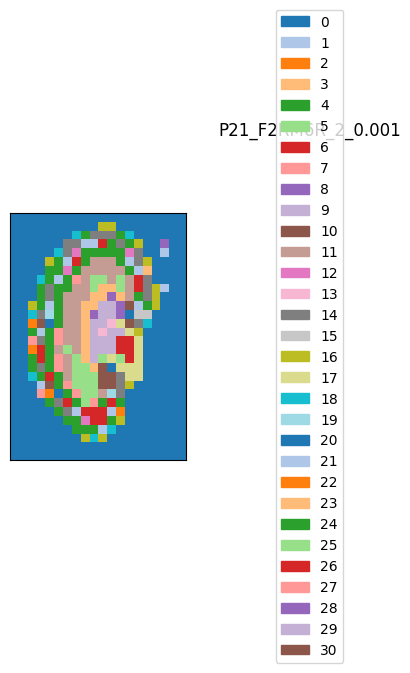

P21_F2RM6R


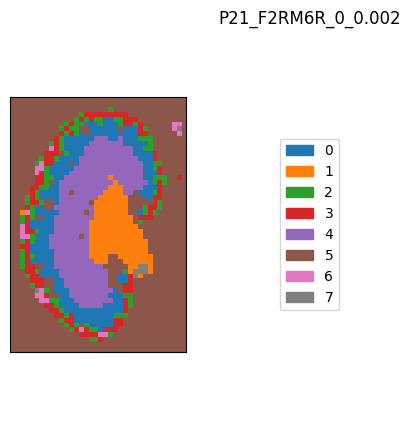

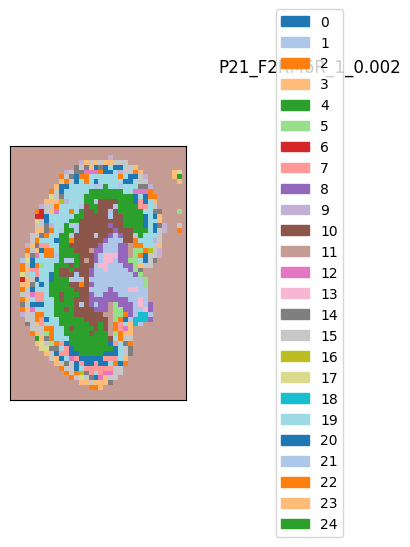

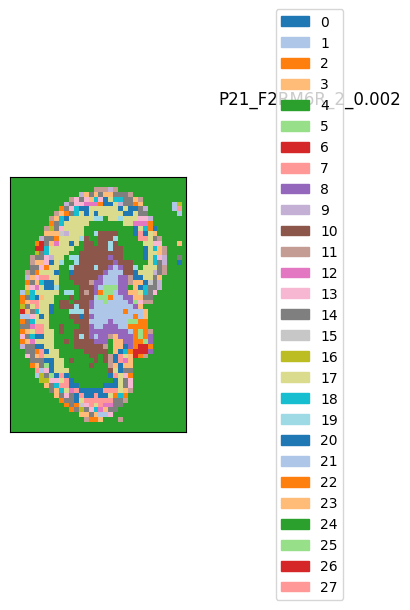

P21_F2RM6R


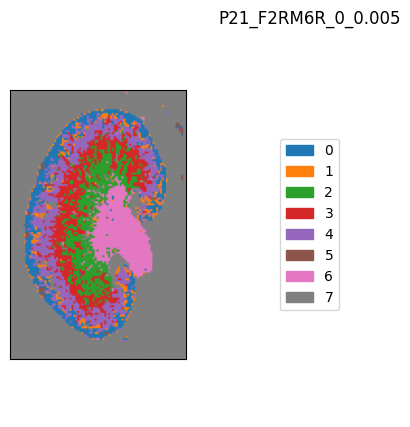

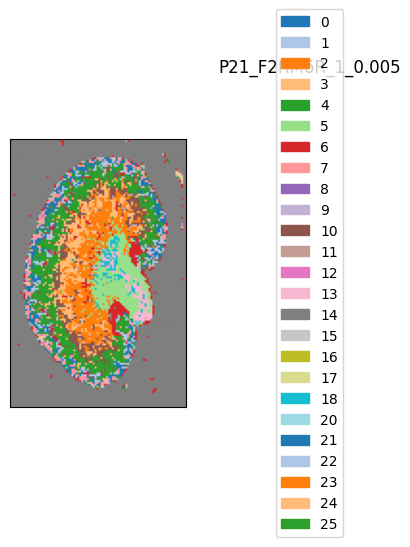

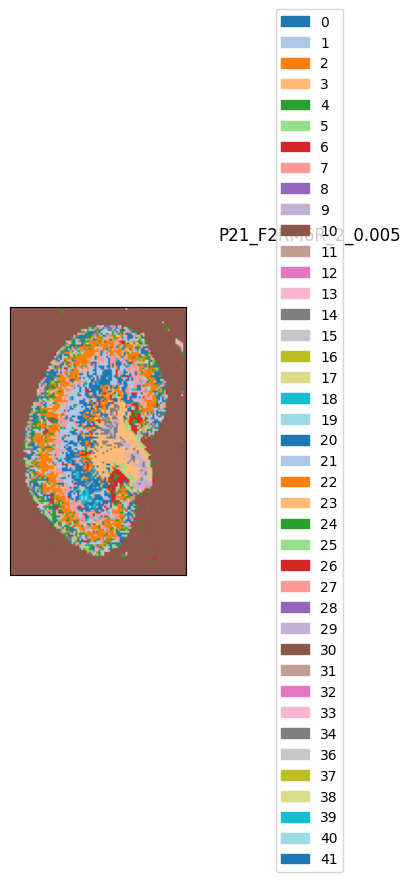

P21_F2RM6R


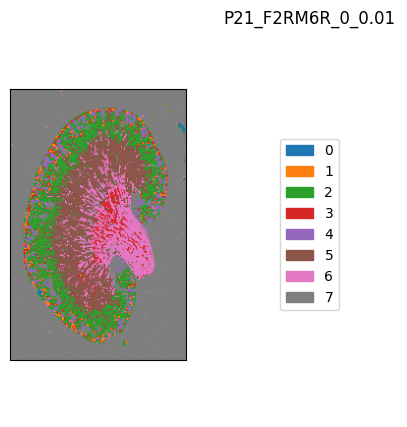

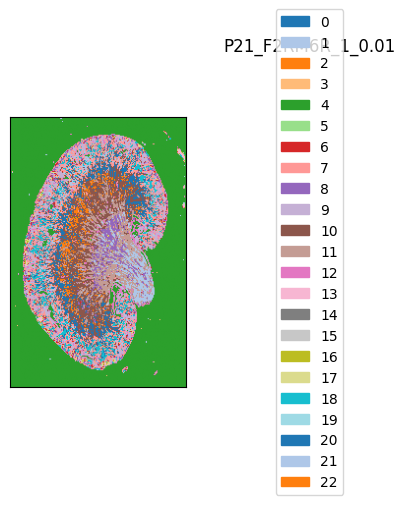

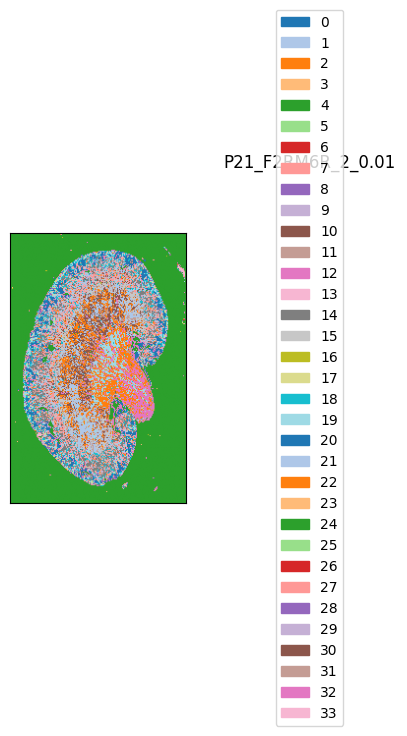

P21_F2RM6R


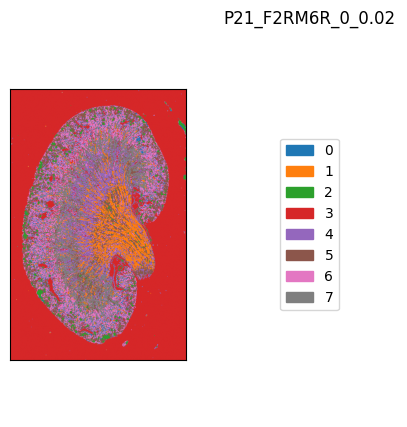

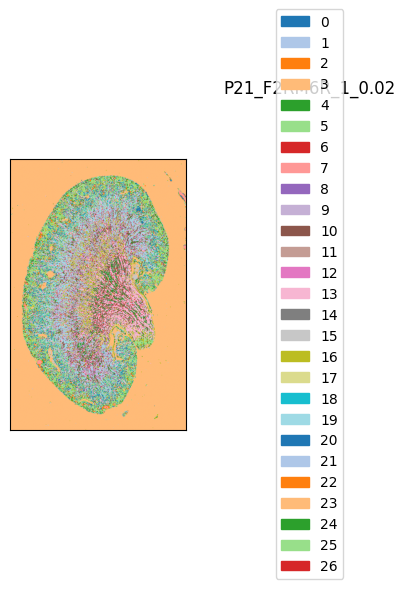

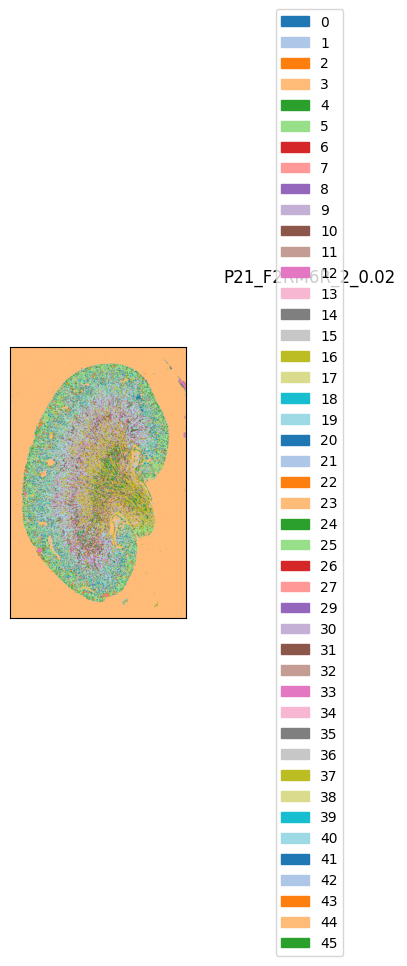

In [23]:
for fp in fps:
    case = fp.split('/')[-3]
    res = re.sub(r'^.*mushroom_(.*)res/outputs.pkl$', r'\1', fp)
    print(case)
    outputs = pickle.load(open(fp, 'rb'))
    k = [x for x in outputs['dtype_to_clusters'].keys() if x != 'integrated'][0]
    clusters = outputs['dtype_to_clusters'][k]
    for i, x in enumerate(clusters):
        vis_utils.display_clusters(x, preserve_indices=True, figsize=(5,5))
        plt.savefig(os.path.join(output_dir, f'{case}_clusters_l{i}_{res}res.pdf'), dpi=300)
        plt.title(f'{case}_{i}_{res}')
        plt.show()

In [81]:
def plot_case(current, transpose=False, hflip=False):
    nrows, ncols = len(levels), len(resolutions)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 2, nrows * 2))
    for fp in fps:
        case = fp.split('/')[-3]
        if case == current:
            res = float(re.sub(r'^.*mushroom_(.*)res/outputs.pkl$', r'\1', fp))

            if res in resolutions:
                outputs = pickle.load(open(fp, 'rb'))
                k = [x for x in outputs['dtype_to_clusters'].keys() if x != 'integrated'][0]
                clusters = outputs['dtype_to_clusters'][k]
                print(len(clusters))
                for level, x in enumerate(clusters):
                    i, j = levels.index(level), resolutions.index(res)
                    ax = axs[i, j]
                    rgb = vis_utils.display_labeled_as_rgb(x[0], preserve_indices=True)
                    if transpose:
                        rgb = rearrange(rgb, 'h w c -> w h c')
                    ax.imshow(rgb)
                    if hflip:
                        ax.invert_xaxis()
                    
                    ax.set_xticks([])
                    ax.set_yticks([])

                    if j == 0:
                        ax.set_ylabel(level)
                    if i == 0:
                        ax.set_title(res)

3
3
3
3


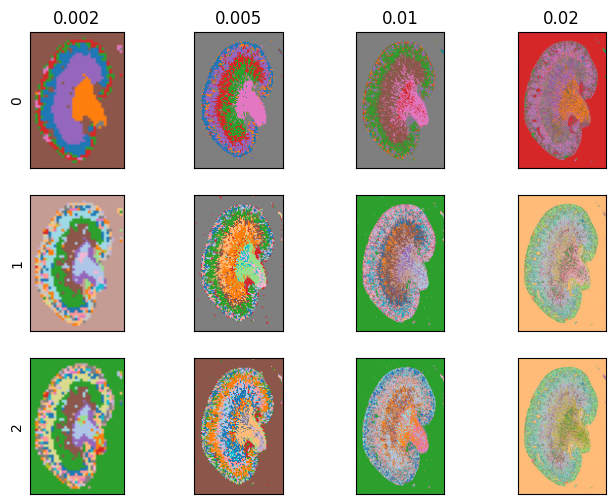

In [82]:
case = 'P21_F2RM6R'
resolutions = [.002, .005, .01, .02]
levels = [0, 1, 2]
plot_case(case)
plt.savefig(os.path.join(output_dir, f'{case}_clusters_mosaic.pdf'), dpi=300)
plt.savefig(os.path.join(output_dir, f'{case}_clusters_mosaic.png'), dpi=300)

3
3
3
3


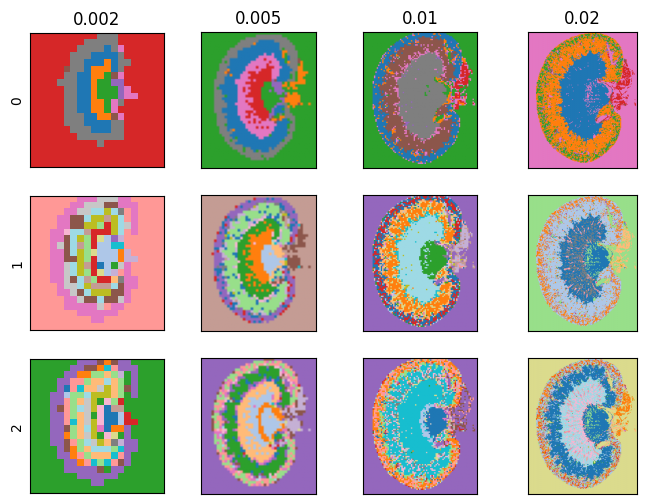

In [83]:
case = 'NMK92F-Fp1'
resolutions = [.002, .005, .01, .02]
levels = [0, 1, 2]
plot_case(case, transpose=True)
plt.savefig(os.path.join(output_dir, f'{case}_clusters_mosaic.pdf'), dpi=300)
plt.savefig(os.path.join(output_dir, f'{case}_clusters_mosaic.png'), dpi=300)

3
3


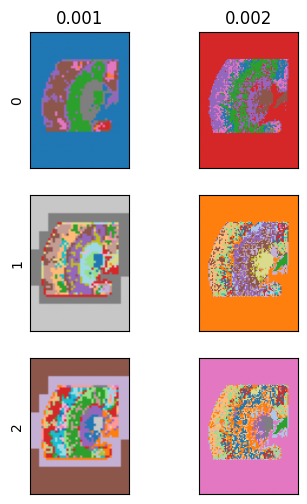

In [84]:
case = 'NMK92F2-Fc1U1Bs2'
resolutions = [.001, .002]
levels = [0, 1, 2]
plot_case(case, transpose=False, hflip=True)
plt.savefig(os.path.join(output_dir, f'{case}_clusters_mosaic.pdf'), dpi=300)
plt.savefig(os.path.join(output_dir, f'{case}_clusters_mosaic.png'), dpi=300)

In [95]:
# transfer xenium nbhds
case = 'NMK92F-Fp1'
resolutions = [.002, .005, .01, .02]
levels = [0, 1, 2]

for res in resolutions:
    directory = os.path.join(project_dir, 'kidney', case, f'mushroom_{res}res')
    mushroom = Mushroom.from_config(directory, accelerator='cpu')
    adata = sc.read_h5ad(mushroom.sections[0]['data'][0]['filepath'])
    pts = adata.obsm['spatial']
    
    df = pd.DataFrame(data=adata.obsm['spatial'], columns=['x', 'y'], index=adata.obs.index.to_list())
    df.index.name = 'barcode'
    for level in levels:
        labels = mushroom.assign_pts(pts, mushroom.section_ids[0], 'xenium', level=level)
        df[f'nbhd level {level}'] = [f'nbhd {x}' for x in labels]
        
    df.to_csv(os.path.join(directory, f'assigned_nbhds.txt'), sep='\t')
    
    del(mushroom)
    del(df)
    

    

INFO:root:loading spore for xenium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting xenium processing
INFO:root:using 479 channels
INFO:root:2 sections detected: ['NMK92F-Fp1-U1', 'NMK92F-Fp1-U1_dup']
INFO:root:processing sections
INFO:root:generating image data for section NMK92F-Fp1-U1
INFO:root:generating image data for section NMK92F-Fp1-U1_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('NMK92F-Fp1-U1', 'xenium'), ('NMK92F-Fp1-U1_dup', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Traine

Predicting: |                                                                                                 …

INFO:root:loading spore for xenium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting xenium processing
INFO:root:using 479 channels
INFO:root:2 sections detected: ['NMK92F-Fp1-U1', 'NMK92F-Fp1-U1_dup']
INFO:root:processing sections
INFO:root:generating image data for section NMK92F-Fp1-U1
INFO:root:generating image data for section NMK92F-Fp1-U1_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('NMK92F-Fp1-U1', 'xenium'), ('NMK92F-Fp1-U1_dup', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Traine

Predicting: |                                                                                                 …

INFO:root:loading spore for xenium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting xenium processing
INFO:root:using 479 channels
INFO:root:2 sections detected: ['NMK92F-Fp1-U1', 'NMK92F-Fp1-U1_dup']
INFO:root:processing sections
INFO:root:generating image data for section NMK92F-Fp1-U1
INFO:root:generating image data for section NMK92F-Fp1-U1_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('NMK92F-Fp1-U1', 'xenium'), ('NMK92F-Fp1-U1_dup', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Traine

Predicting: |                                                                                                 …

INFO:root:loading spore for xenium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting xenium processing
INFO:root:using 479 channels
INFO:root:2 sections detected: ['NMK92F-Fp1-U1', 'NMK92F-Fp1-U1_dup']
INFO:root:processing sections
INFO:root:generating image data for section NMK92F-Fp1-U1
INFO:root:generating image data for section NMK92F-Fp1-U1_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('NMK92F-Fp1-U1', 'xenium'), ('NMK92F-Fp1-U1_dup', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Traine

Predicting: |                                                                                                 …

In [97]:
df = pd.read_csv(
    '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92F-Fp1/mushroom_0.002res/assigned_nbhds.txt',
    sep='\t'
)
df

barcode     x     y nbhd level 0 nbhd level 1 nbhd level 2
0       aaaaabca-1   837  6829       nbhd 3      nbhd 12       nbhd 8
1       aaaahkjg-1  2485   802       nbhd 3       nbhd 7       nbhd 4
2       aaababbf-1  2475   819       nbhd 3       nbhd 7       nbhd 4
3       aaabapop-1  2487   833       nbhd 3       nbhd 7       nbhd 4
4       aaabbbfb-1  2497   788       nbhd 3       nbhd 7       nbhd 4
...            ...   ...   ...          ...          ...          ...
421135  oiiedjek-1  9171  4289       nbhd 3       nbhd 7       nbhd 4
421136  oiieifmp-1  9169  4260       nbhd 3       nbhd 7       nbhd 4
421137  oiiejfdd-1  9173  4251       nbhd 3       nbhd 7       nbhd 4
421138  oiielmoo-1  9169  4314       nbhd 3       nbhd 7       nbhd 4
421139  oiieogef-1  9178  4300       nbhd 3       nbhd 7       nbhd 4

[421140 rows x 6 columns]

In [85]:
directory = '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92F-Fp1/mushroom_0.002res'
mushroom = Mushroom.from_config(directory, accelerator='cpu')

INFO:root:loading spore for xenium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting xenium processing
INFO:root:using 479 channels
INFO:root:2 sections detected: ['NMK92F-Fp1-U1', 'NMK92F-Fp1-U1_dup']
INFO:root:processing sections
INFO:root:generating image data for section NMK92F-Fp1-U1
INFO:root:generating image data for section NMK92F-Fp1-U1_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('NMK92F-Fp1-U1', 'xenium'), ('NMK92F-Fp1-U1_dup', 'xenium')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpzdlpqqvu
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpzdlpqqvu/_remote_module_non_scriptable.py
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU avail

Predicting: |                                                                                                 …

In [87]:
adata = sc.read_h5ad(mushroom.sections[0]['data'][0]['filepath'])
adata

AnnData object with n_obs × n_vars = 421140 × 479
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'ppm', 'spatial'
    obsm: 'spatial'

In [88]:
pts = adata.obsm['spatial']

labels = mushroom.assign_pts(pts, mushroom.section_ids[0], 'xenium', level=0)


array([0, 1, 2, 3, 4, 5, 6, 7])

In [65]:
adata = sc.read_h5ad('/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92F-Fp1/registered/NMK92F-Fp1_xenium.h5ad')
adata

AnnData object with n_obs × n_vars = 421140 × 479
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'ppm', 'spatial'
    obsm: 'spatial'

In [70]:
hires = next(iter(adata.uns['spatial'].values()))['images']['hires']
hires = rearrange(hires, 'h w -> w h')
hires.shape

(4836, 3753)

In [76]:
tifffile.imwrite('/data/estorrs/sandbox/NMK92F-Fp1_dna.tif', hires)